In [1]:
# Tarvittavien kirjastojen tuonti
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt

In [2]:
DATAN_POLKU = "../data/kappaleet.npz"

DATAN_POLKU = "../data/kappaleet.npz"

def lataa_data():
    data = np.load(DATAN_POLKU, allow_pickle=True)

    # Accessing the training and testing data
    X_train = data['X_train']
    y_train = data['y_train']
    X_test = data['X_test']
    y_test = data['y_test']
    labels = data['labels']
    
    return X_train, y_train, X_test, y_test, labels



X_train, y_train, X_test, y_test, labels = lataa_data()

print("X_train:", X_train.shape)
print("y_train:", y_train.shape)
print("X_test:", X_test.shape)
print("y_test:", y_test.shape)
print("labels:", labels)


X_train: (1387, 64, 862)
y_train: (1387, 3)
X_test: (347, 64, 862)
y_test: (347, 3)
labels: ['fusku' 'salsa' 'valssi']


In [3]:
from tensorflow.keras.layers import Input, Conv2D, Flatten, Dense, Dropout, BatchNormalization, MaxPooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from tensorflow.keras import backend as K
from tensorflow.keras import saving
from tensorflow import keras


# metriikka mallin arvioimiseksi
@saving.register_keras_serializable()
def metric(y_true, y_pred):
    return K.mean(K.equal(K.argmax(y_true, axis=1), K.argmax(y_pred, axis=1)))

# CNN-mallin määrittely
model = Sequential([
    Input(shape=(X_train.shape[1], X_train.shape[2], 1)),
    Conv2D(64, kernel_size=(4, 4), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 4)),
    Conv2D(64, (3, 5), activation='relu'
                    , kernel_regularizer=regularizers.l2(0.04)
                    ),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.2),
    Conv2D(64, (2, 2), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.2),
    Flatten(),
    Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.04)),
    Dropout(0.5),
    Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.04)),
    Dense(y_train.shape[1], activation='softmax')
])

# Mallin kokoaminen
model.compile(optimizer=Adam(),
              loss='categorical_crossentropy',
              metrics=[metric])

In [4]:
#visualize the model
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 61, 859, 64)    │         1,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 61, 859, 64)    │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 30, 214, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 28, 210, 64)    │        61,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 14, 105, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 14, 105, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 13, 104, 64)    │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 13, 104, 64)    │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 52, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 6, 52, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 19968)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │     1,278,016 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,359,747 (5.19 MB)

 Trainable params: 1,359,491 (5.19 MB)

 Non-trainable params: 256 (1.00 KB)

In [5]:
# Mallin kouluttaminen
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))

Epoch 1/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 73s 2s/step - loss: 10.9903 - metric: 0.4243 - val_loss: 7.5811 - val_metric: 0.2723
Epoch 2/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 67s 2s/step - loss: 6.5537 - metric: 0.3489 - val_loss: 4.6666 - val_metric: 0.5180
Epoch 3/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 68s 2s/step - loss: 4.2316 - metric: 0.4558 - val_loss: 3.0523 - val_metric: 0.5895
Epoch 4/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 67s 2s/step - loss: 2.8584 - metric: 0.4960 - val_loss: 4.4757 - val_metric: 0.4870
Epoch 5/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 67s 2s/step - loss: 2.1462 - metric: 0.5242 - val_loss: 1.8413 - val_metric: 0.6316
Epoch 6/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 67s 2s/step - loss: 1.7751 - metric: 0.5710 - val_loss: 1.2755 - val_metric: 0.7753
Epoch 7/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 67s 2s/step - loss: 1.3529 - metric: 0.6986 - val_loss: 1.3249 - val_metric: 0.7321
Epoch 8/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 68s 2s/step - loss: 1.2537 - metric: 0.7266 - val_loss: 0.9950 - val_metric: 0.8871
Epoch 9/10
44/44 ━━━━━━

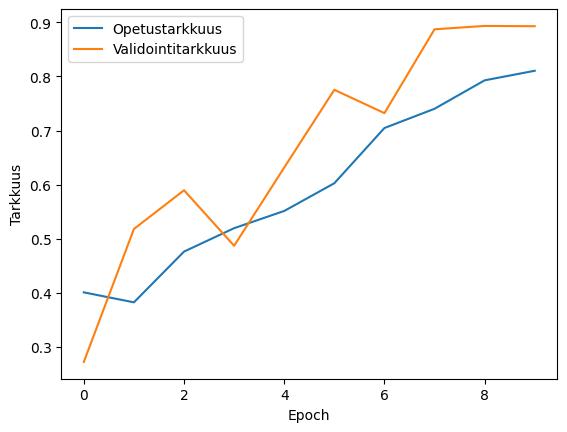

In [6]:
# Mallin suorituskyvyn evaluointi
plt.plot(history.history['metric'], label='Opetustarkkuus')
plt.plot(history.history['val_metric'], label='Validointitarkkuus')
plt.xlabel('Epoch')
plt.ylabel('Tarkkuus')
plt.legend()
plt.show()

In [7]:
VALIDOINTI_DATAN_POLKU = "../data/validointi.npz"

data = np.load(VALIDOINTI_DATAN_POLKU, allow_pickle=True)

X_val = data['X_val']
y_val = data['y_val']
labels = data['labels']

print("X_val:", X_val.shape)
print("y_val:", y_val.shape)
print("labels:", labels)

X_val: (98, 64, 862)
y_val: (98, 3)
labels: ['fusku' 'salsa' 'valssi']


4/4 - 1s - 284ms/step - loss: 0.9630 - metric: 0.6484
Malli saavutti validoinnissa 64.84% tarkkuuden
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 206ms/step
True Real: salsa, Predicted: salsa, Confidence: 1.00
True Real: salsa, Predicted: salsa, Confidence: 1.00
True Real: salsa, Predicted: salsa, Confidence: 1.00
True Real: salsa, Predicted: salsa, Confidence: 1.00
True Real: salsa, Predicted: salsa, Confidence: 0.80
True Real: salsa, Predicted: salsa, Confidence: 1.00
True Real: salsa, Predicted: salsa, Confidence: 1.00
True Real: salsa, Predicted: salsa, Confidence: 1.00
True Real: salsa, Predicted: salsa, Confidence: 1.00
True Real: salsa, Predicted: salsa, Confidence: 1.00
True Real: salsa, Predicted: salsa, Confidence: 1.00
True Real: salsa, Predicted: salsa, Confidence: 0.95
True Real: salsa, Predicted: salsa, Confidence: 1.00
True Real: salsa, Predicted: salsa, Confidence: 0.60
True Real: salsa, Predicted: salsa, Confidence: 1.00
False Real: salsa, Predicted: valssi, Confidence: 0.55
True Real:

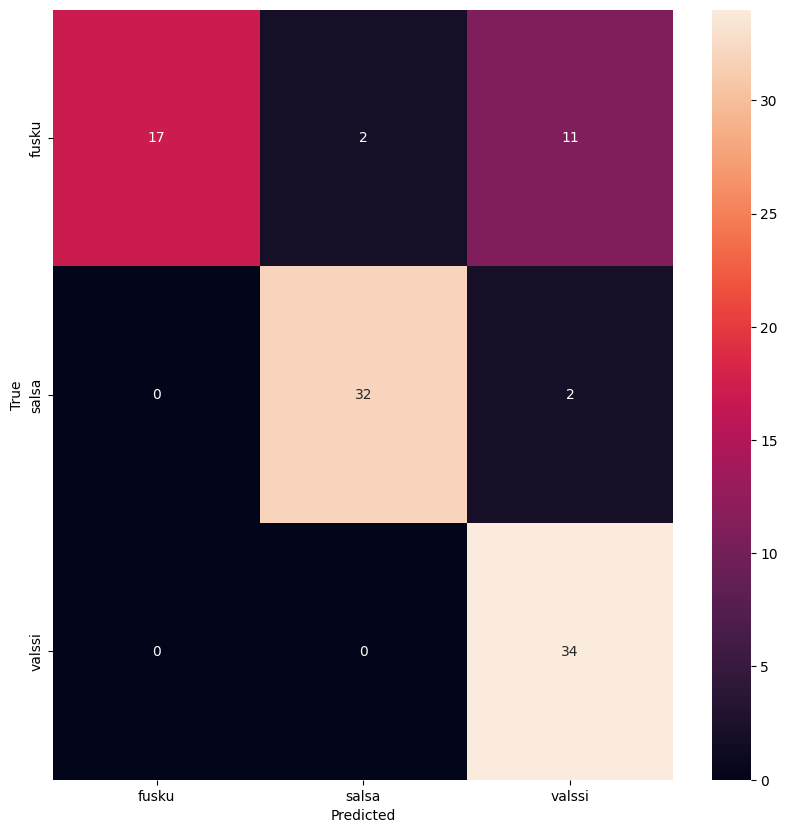

In [11]:

from tensorflow.keras.models import load_model

#load the model
#model = load_model('model_3_genres_best.keras')

#evaluate the model on the validation data
test_loss, test_acc = model.evaluate(X_val, y_val, verbose=2)
print(f'Malli saavutti validoinnissa {test_acc*100:.2f}% tarkkuuden')    

#predict the labels for the validation data
predicted_labels_one_hot = model.predict(X_val)
indices = np.argmax(predicted_labels_one_hot, axis=1)
predicted_labels = labels[indices]

true_labels = labels[np.argmax(y_val, axis=1)]

# Get the confidence (probability) of the predicted class
predicted_confidence = np.max(predicted_labels_one_hot, axis=1)

# Print the true and predicted labels for the first 10 examples
for i in range(len(predicted_labels)):
    prediction_true = true_labels[i] == predicted_labels[i]
    print(f'{prediction_true} Real: {true_labels[i]}, Predicted: {predicted_labels[i]}, Confidence: {predicted_confidence[i]:.2f}')

#plot the confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(true_labels, predicted_labels, labels=labels)
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


In [10]:
# save the model whit the best accuracy
model.save('model_3_genres_best.keras')
print('Malli tallennettu tiedostoon')

Malli tallennettu tiedostoon
